In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
np.random.seed(seed=2554)

#Simulating Data - First Steps

segment_variables = ['age','gender','income','kids','own_home','subscribe']
segment_variables_distribution = dict(zip(segment_variables,
                                          ['normal','binomial',
                                          'normal','poisson',
                                          'binomial', 'binomial']))

#defining the statistics for ea. variable in segment
segment_means = {'suburb_mix': [40, 0.5, 55000,2, 0.5, 0.1],
                 'urban_hip':  [24, 0.7, 21000, 1, 0.2, 0.2],
                 'travelers' : [58, 0.5, 64000, 0, 0.7, 0.05],
                 'moving_up' : [36, 0.3, 52000, 2, 0.3, 0.2]} 

#Standard Deviations for Each Segment
# None = not applicable for the variable
segment_stddev = {'suburb_mix': [5, None, 12000, None, None, None],
                 'urban_hip':  [2, None, 5000,  None, None, None],
                 'travelers' : [8, None, 21000,  None, None, None],
                 'moving_up' : [4, None, 10000,  None, None, None]} 

#Setting segment sizes 
segment_names = ['suburb_mix','urban_hip','travelers','moving_up']
segment_sizes = dict(zip(segment_names,[100, 50, 80, 70]))

segment_statistics = {}
for name in segment_names:
    segment_statistics[name] = {'size' : segment_sizes[name]}
    for i, variable in enumerate(segment_variables):
        segment_statistics[name][variable] = {
            'mean' : segment_means[name][i],
            'stddev' : segment_stddev[name][i]
        }


#Final Segment Data Generation

#Pseudocode
#set up dictionary "segment_constructor" and pseudorandom number sequence
#For each SEGMENT i in "segment_names" {
#   Set up a temporary dictionary "segment_data_subset" for this SEGMENTS data
#   For each Variable in "seg_variables"{
#       Check "segment_variables_distribution[variable]" to find distribution type for VARIABLE

#       Look up the segment size and variable mean and standard deviation in segment_Statistics for
#       that SEGMENT and VARIABLE to 
#       ... Draw random data for VARIABLE (within SEGMENT) with
#       ... "size" observations
#       }
# Add this SEGMENT's data ("segment_data_subset") to the overall data ("segment_constructor")

# Create a DataFrame "segment_data" from "segment_constructors"
#}

segment_constructor = {}

#Iterate over segments to create data for each
for name in segment_names:
    size = segment_statistics[name]['size']
    segment_data_subset = {}

    #Within each segment, iterate over the variables and generate data
    for variable in segment_variables:
        if segment_variables_distribution[variable] == 'normal':
            #Draw random normals
            segment_data_subset[variable] = np.random.normal(
                loc = segment_statistics[name][variable]['mean'],
                scale = segment_statistics[name][variable]['stddev'],
                size = size
            )
        elif segment_variables_distribution[variable] == 'poisson':
            #Draw counts
            segment_data_subset[variable] = np.random.poisson(
                lam = segment_statistics[name][variable]['mean'],
                size = size
            )
        elif segment_variables_distribution[variable] == 'binomial':
            #Draw binomial
            segment_data_subset[variable] = np.random.binomial(
                n = 1,
                p = segment_statistics[name][variable]['mean'],
                size = size
            )
        else:
            #Data type unkown
            print('Bad segment data type:{0}'.format(
                segment_variables_distribution[j])
                )
            raise StopIteration
        segment_data_subset['Segment'] = np.repeat(
            name,
            repeats = segment_statistics[name]['size']
        )
        segment_constructor[name] = pd.DataFrame(segment_data_subset)
    segment_data = pd.concat(segment_constructor.values())

segment_data['gender'] = segment_data['gender'].apply(lambda x: 'male' if x else 'female')
segment_data['own_home'] = segment_data['own_home'].apply(lambda x: True if x else False)
segment_data['subscribe'] = segment_data['subscribe'].apply(lambda x: True if x else False)

segment_data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,300.0,NaN,NaN,NaN,40.92335,12.827494,18.38873,32.870035,38.896711,47.987569,79.650722
Segment,300,4,suburb_mix,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,300,2,male,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income,300.0,NaN,NaN,NaN,50669.454237,19336.497748,11297.309231,41075.804389,51560.344807,62172.668698,108830.388732
kids,300.0,NaN,NaN,NaN,1.273333,1.413725,0.0,0.0,1.0,2.0,7.0
own_home,300,2,False,167,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subscribe,300,2,False,265,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#How to find the mean of the moving up segment
segment_data.loc[segment_data.Segment == 'moving_up']['income'].mean()

#Narrow it down to those who don't subscribe
segment_data.loc[(segment_data['Segment'] == 'moving_up') &
                 (segment_data['subscribe'] == False)]['income'].mean()

#Using group by to get the values for all groups
segment_data.groupby('Segment')['income'].mean()

#breaking out by multiple factors
segment_data.groupby(['Segment','subscribe'])['income'].mean()

#Using unstack to get a nicer looking format
segment_data.groupby(['Segment','subscribe'])['income'].mean().unstack()

#Adding segment mean to all 
segment_income = segment_data.groupby('Segment')['income'].mean() 
segment_data = segment_data.join(segment_income,
                                 on = 'Segment',
                                 rsuffix= '_segment')
segment_data.head(3)

#Using .drop to get rid of derived column
segment_data.drop(labels = 'income_segment', axis = 1, inplace = True)
segment_data.head(3)

#Use groupby() to agg across mult factors
segment_data.groupby(['Segment','own_home'])['income'].mean()

#Extending with additional variables
segment_data.groupby(['Segment','own_home','subscribe'])['income'].mean()

#Unstack to make it easier to read:
segment_data.groupby(['Segment','own_home','subscribe'])['income'].mean().unstack()

#Using groupby and count to look at frequency
segment_data.groupby(
    ['Segment','own_home',]
)['subscribe'].count().unstack()

#Segment by kids in ea. household
segment_data.groupby(
    ['kids','Segment']
    ).subscribe.count().unstack(level = 1)

#Use the crosstabs function to get the same
pd.crosstab(segment_data['kids'],segment_data['Segment'])

#Total number of kids per segment
segment_data.groupby('Segment')['kids'].sum()



Segment
moving_up     130
suburb_mix    195
travelers       0
urban_hip      57
Name: kids, dtype: int64

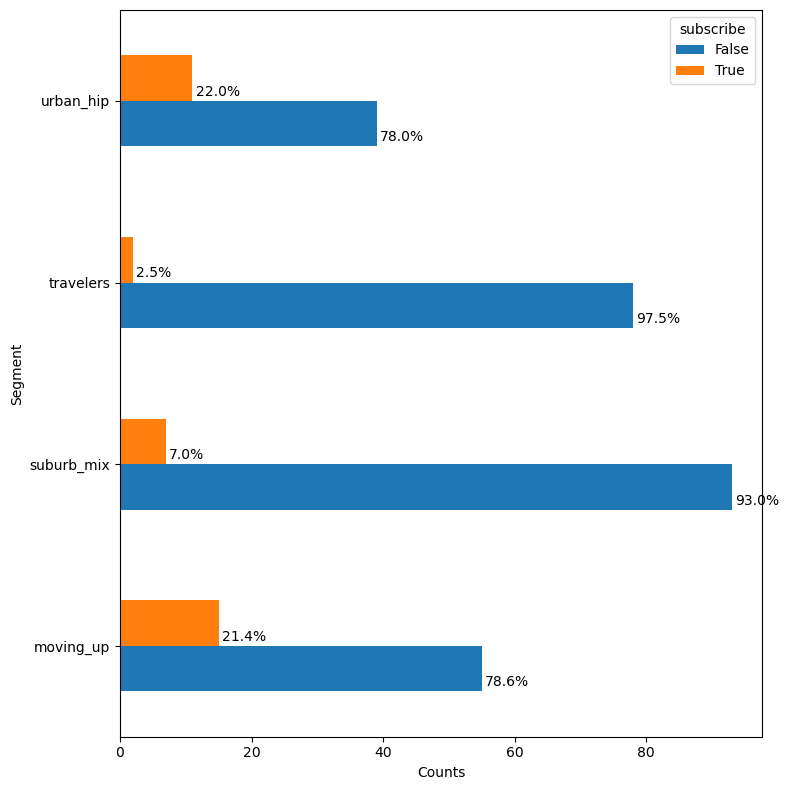

/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


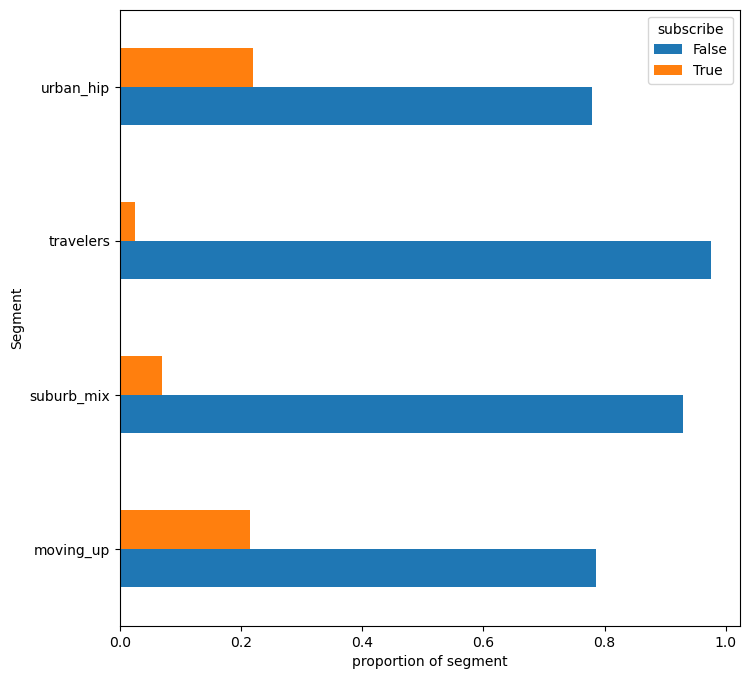

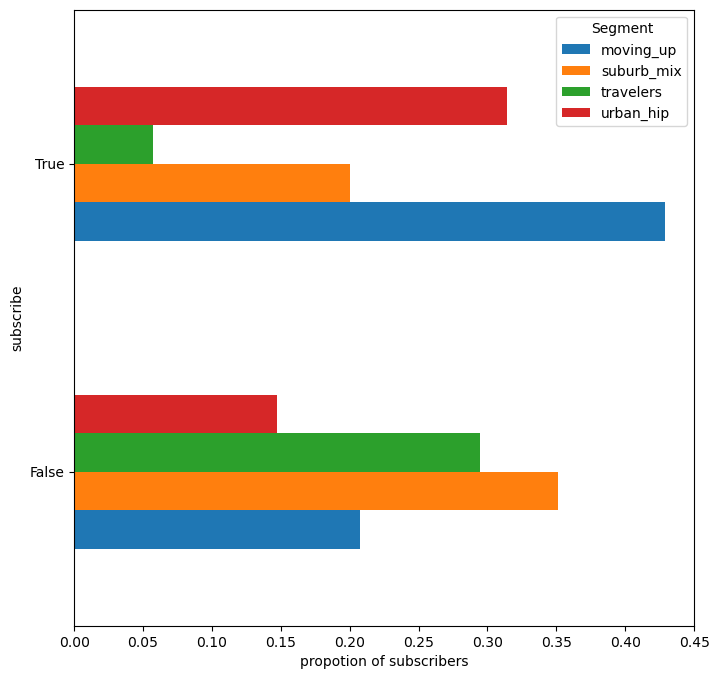

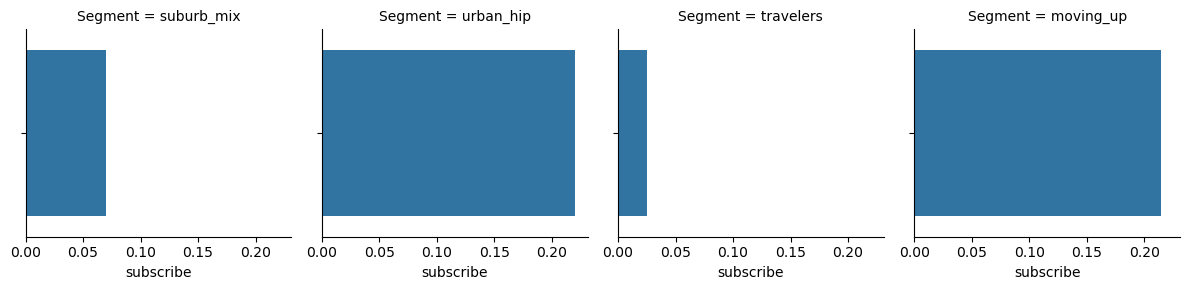

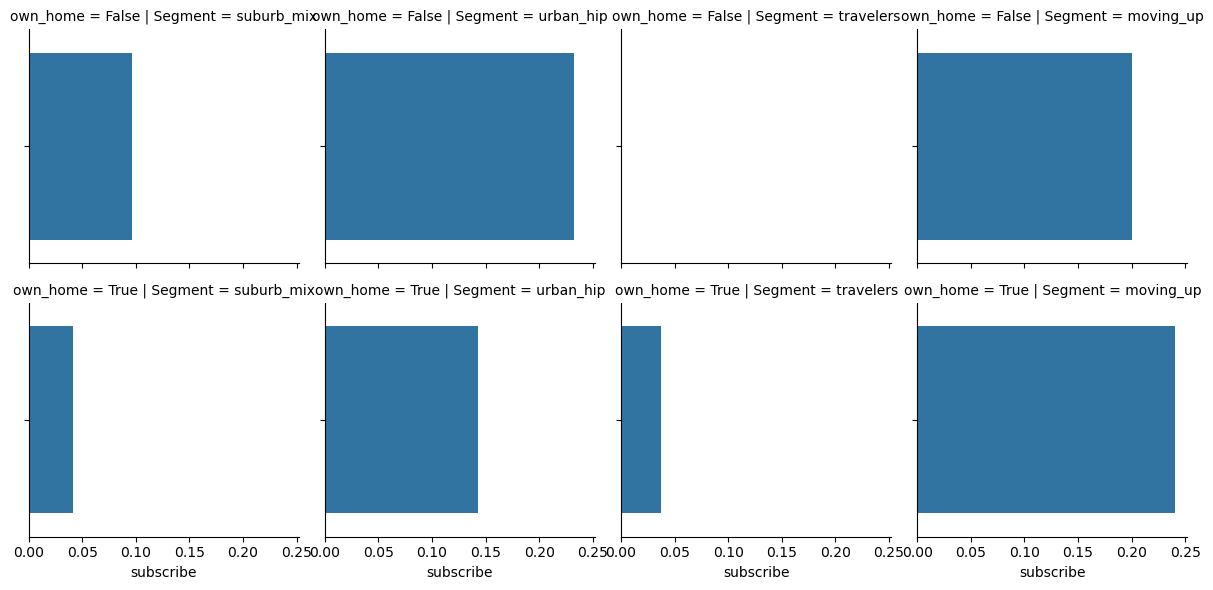

In [33]:
#Visualization by Group: Frequency & Proportions

import matplotlib.pyplot as plt

#Subscription by segment graphed w/ percentages
# Group and count
segments_groupby_segments = segment_data.groupby(['Segment'])
count_data = segments_groupby_segments['subscribe'].value_counts().unstack()

ax = count_data.plot(
    kind='barh',
    figsize=(8, 8)
)
plt.xlabel('Counts')

# Add percentages
for i, (index, row) in enumerate(count_data.iterrows()):
    total = row.sum()
    for j, value in enumerate(row):
        percent = value / total * 100 if total > 0 else 0
        ax.text(value + 0.5, i - 0.2 + j * 0.25, f'{percent:.1f}%', va='center')

plt.tight_layout()
plt.show()

#Normalize to get proportion in ea segment
segments_groupby_segments['subscribe'].value_counts(
    normalize = True
).unstack().plot(
    kind = 'barh',
    figsize = (8, 8)
)
plt.xlabel('proportion of segment')

#looking at subscription status then segments
segment_data.groupby(['subscribe'])['Segment'].value_counts(
    normalize = True
).unstack().plot(kind = 'barh',figsize = (8,8))
plt.xlabel('propotion of subscribers')

#Using seaborn to geneate similar graphs
# import seaborn as sns 

# sns.barplot(y = 'Segment', x = 'subscribe', data = segment_data,
#             orient = 'h', errorbar=None)


#Using seaborn and facetgrid() for multi panel
g = sns.FacetGrid(segment_data, col = 'Segment')
g.map(sns.barplot,'subscribe', errorbar=None)

#Looking at another factor makes it more informative
g = sns.FacetGrid(segment_data, col = 'Segment', row = 'own_home')
g.map(sns.barplot,'subscribe', errorbar = None)


In [ ]:
#Visualization by Group: Continuous Data
